In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
from PyFin.api import *
from alphamind.api import *
from matplotlib import pyplot as plt
import time
import seaborn
seaborn.set_style('whitegrid')

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
%matplotlib inline

In [2]:
from sqlalchemy import select, and_, or_
from PyFin.api import advanceDateByCalendar, bizDatesList
from alphamind.data.dbmodel.models import Market, IndexMarket, DailyPortfolios, PnlLog, Universe, RiskExposure
from alphamind.data.dbmodel.models import Industry, PortfoliosRebalanceLog, IndexComponent
from AlphaDesign.Utilities.alphamind_tool import engine_postgres
from AlphaDesign.Utilities.math import winsorize

In [3]:
## 通过 uqer.DataAPI 访问
import uqer
from uqer import DataAPI
from uqer import DataAPI as api
# client = uqer.Client(token='')

def uqer_sdk_login():
    os.environ['access_token'] = ''
    
uqer_sdk_login()

# data

In [4]:
def risk_get(begin, end):
    # exposure data
    query = select([RiskExposure]).where(
        and_(
            RiskExposure.trade_date >= begin,
            RiskExposure.trade_date <= end,
        )
    ).order_by(RiskExposure.trade_date)
    risk_df = pd.read_sql(query, engine_postgres.session.bind)
    risk_df = risk_df.set_index(['trade_date', 'code'])
    return risk_df


def idxcon_get(begin, end):
    # index components data
    query = select([IndexComponent.trade_date, IndexComponent.code, IndexComponent.weight]).where(
        and_(
            IndexComponent.trade_date >= begin,
            IndexComponent.trade_date <= end,
            IndexComponent.indexShortName == '中证500',
            IndexComponent.indexCode == 905
        ))
    idxcon_df = pd.read_sql(query, engine_postgres.session.bind)
    idxcon_df['weight'] = idxcon_df['weight'] / 100.0
    idxcon_df.columns = ['trade_date', 'code', 'zz500']
    return idxcon_df

In [5]:
# begin_date = '20140101'

# fund_ticker = '460009'

In [6]:
begin_date = '20100101'

fund_list = ['001243','000478','161017','000978','002906','460009','519983','003986']
report_date_list = ['2010-12-31', '2011-06-30', '2011-12-31', '2012-06-30',
                    '2012-12-31', '2013-06-30', '2013-12-31', '2014-06-30',
                    '2014-12-31', '2015-06-30', '2015-12-31', '2016-06-30',
                    '2016-12-31', '2017-06-30', '2017-12-31', '2018-06-30',
                    '2018-12-31', '2019-06-30']

In [7]:
fund_df = DataAPI.FundHoldingsGet(ticker=fund_list,reportDate=u"",beginDate=begin_date,endDate=u"",secType="",field=u"",pandas="1")
# fund_equ_weight_df = fund_df.groupby(['reportDate','ticker'])['ratioInNa'].sum().unstack()
# se = fund_equ_weight_df[fund_equ_weight_df>0.7].mean(axis=1)
# se[se>0].index
fund_df.rename(columns={'holdingTicker': 'code'}, inplace=True)

fund_df = fund_df[[x in report_date_list for x in fund_df.reportDate]]
fund_df['code'] = fund_df['code'].astype(int)
fund_df['ratioInNa'] = fund_df['ratioInNa'] / 100.0
fund_df['reportDate'] = pd.to_datetime(fund_df['reportDate'])
fund_df.head()

fund_tic_map = {fund_df['ticker'][x]: fund_df['SecShortName'][x] for x in fund_df.index}

fund_tb = fund_df.set_index(['reportDate', 'code', 'ticker'])['ratioInNa'].unstack()
fund_tb.head()

ticker           000478  000978  001243  002906  003986  161017  460009  \
reportDate code                                                           
2010-12-31 1        NaN     NaN     NaN     NaN     NaN     NaN  0.0135   
           2        NaN     NaN     NaN     NaN     NaN     NaN  0.0008   
           16       NaN     NaN     NaN     NaN     NaN     NaN  0.0022   
           39       NaN     NaN     NaN     NaN     NaN     NaN  0.0093   
           43       NaN     NaN     NaN     NaN     NaN     NaN  0.0025   

ticker           519983  
reportDate code          
2010-12-31 1        NaN  
           2        NaN  
           16       NaN  
           39       NaN  
           43       NaN

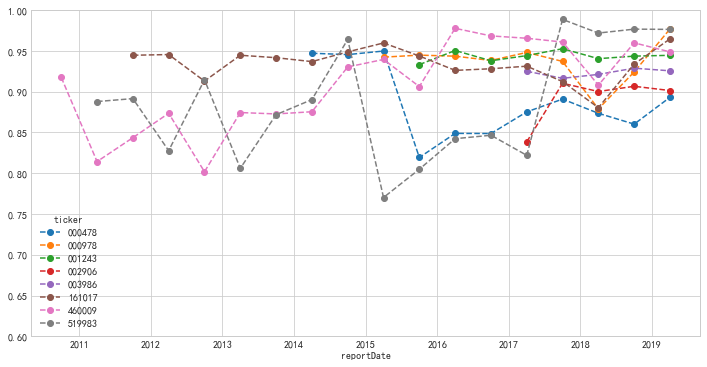

In [8]:
ax = fund_df.groupby(['reportDate','ticker'])['ratioInNa'].sum().unstack().plot(style='--o', figsize=(12, 6))
ax.set_ylim([0.6, 1.0]);

In [9]:
exp_df = pd.DataFrame()
rel_exp_df = pd.DataFrame()

date = report_date_list[0]
for date in report_date_list:
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    biz_date = advanceDateByCalendar('China.SSE', date, '-1b')

    port_df = fund_tb.loc[date]
    risk_df = risk_get(biz_date, biz_date).reset_index(level='trade_date').drop('trade_date', axis=1)
    idxcon_df = idxcon_get(biz_date, biz_date).drop('trade_date', axis=1).set_index(['code'])
    port_df = idxcon_df.join(port_df, how='outer')
    port_df = port_df.apply(lambda x: x / x.sum())
    port_df.fillna(0.0, inplace=True)
    port_list = port_df.columns
    
    codes_list = port_df.index.intersection(risk_df.index)
    port_df = port_df.loc[codes_list]
    risk_df = risk_df.loc[codes_list]
    
    risk_exp_df = port_df.T.dot(risk_df).T
    weight_se = risk_exp_df.loc['COUNTRY']
    risk_exp_df[weight_se[weight_se<0.9].index] = np.NaN

    risk_rel_exp_df = risk_exp_df.apply(lambda x: x - risk_exp_df['zz500'])

    risk_exp_df.index.name = 'risk'
    risk_exp_df = risk_exp_df.reset_index()
    risk_exp_df['date'] = date
    risk_rel_exp_df.index.name = 'risk'
    risk_rel_exp_df = risk_rel_exp_df.reset_index()
    risk_rel_exp_df['date'] = date

    exp_df = exp_df.append(risk_exp_df)
    rel_exp_df = rel_exp_df.append(risk_rel_exp_df)
    
    print(date.strftime('%Y%m%d'), end=', ')

20101231, 20110630, 20111231, 20120630, 20121231, 20130630, 20131231, 20140630, 20141231, 20150630, 20151231, 20160630, 20161231, 20170630, 20171231, 20180630, 20181231, 20190630, 

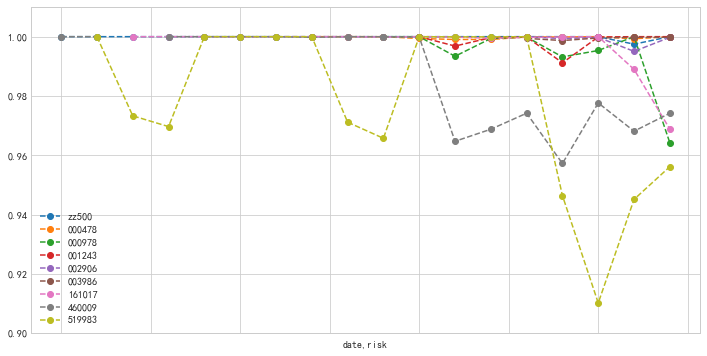

In [10]:
ax = exp_df[exp_df.risk=='COUNTRY'].set_index(['date','risk']).plot(style='--o', figsize=(12, 6))
ax.set_ylim([0.9, 1.01]);

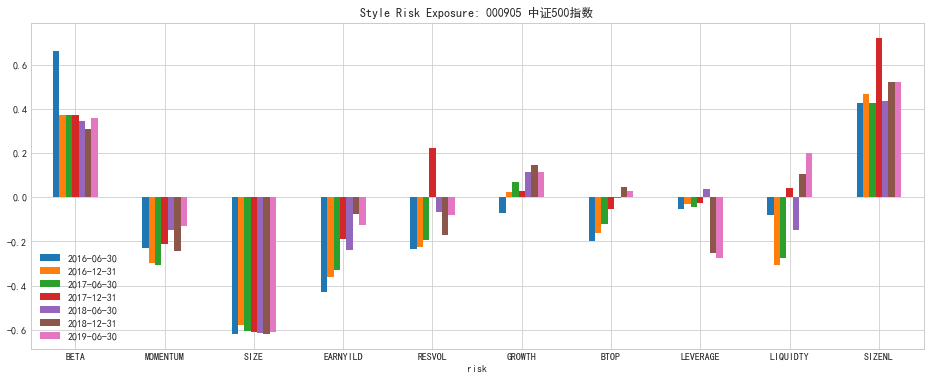

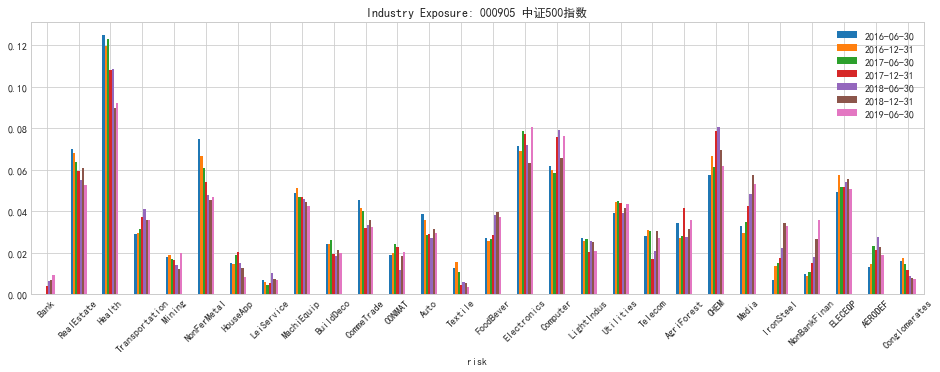

In [11]:
bench_exp_df = exp_df.set_index(['date', 'risk'])['zz500'].unstack()

plot_df = bench_exp_df
plot_df = plot_df[plot_df.index>'20160101']
plot_df = plot_df.T
plot_df.columns = [x.strftime('%Y-%m-%d') for x in plot_df.columns]


ax = plot_df.loc[risk_styles].plot(kind='bar', figsize=(16, 6));
ax.set_xticklabels(plot_df.loc[risk_styles].index, rotation=0);
ax.set_title('Style Risk Exposure: ' + '000905' + ' ' + '中证500指数');
ax = plot_df.loc[industry_styles].plot(kind='bar', figsize=(16, 5));
ax.set_xticklabels(plot_df.loc[industry_styles].index, rotation=45);
ax.set_title('Industry Exposure: ' + '000905' + ' ' + '中证500指数');

In [12]:
plot_rel_exp_df = rel_exp_df.set_index(['date', 'risk']).drop('zz500', axis=1)

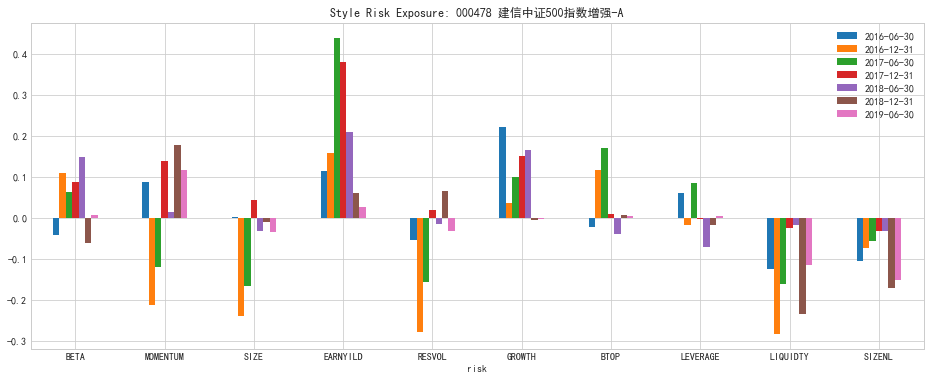

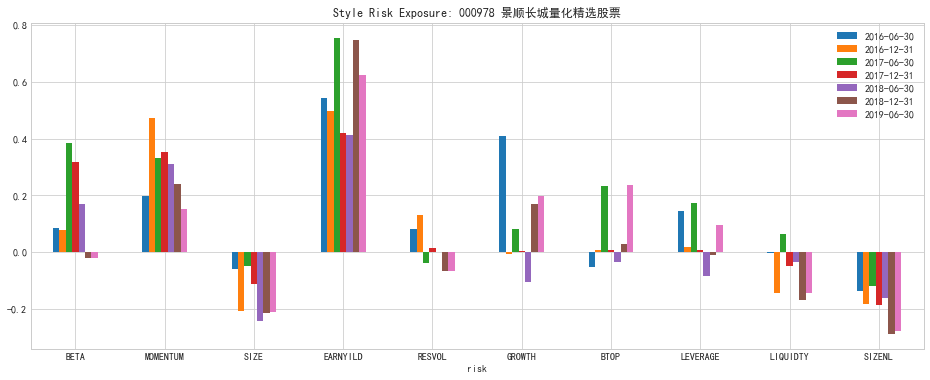

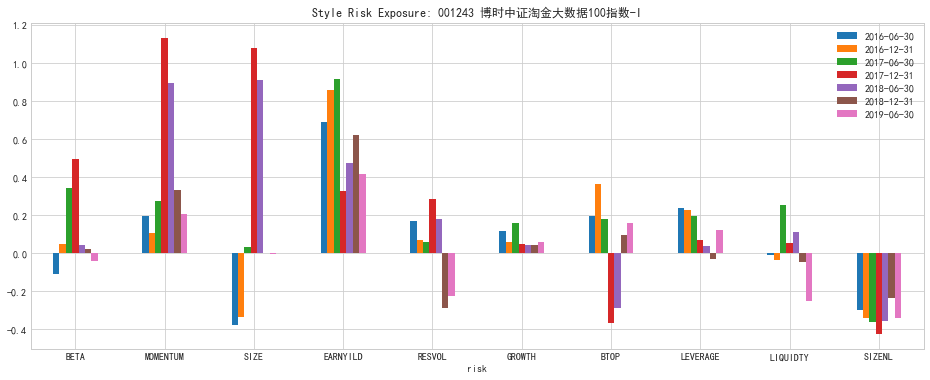

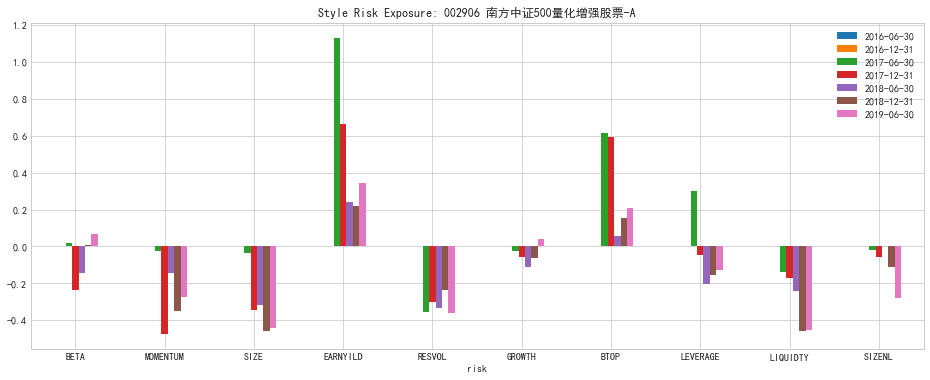

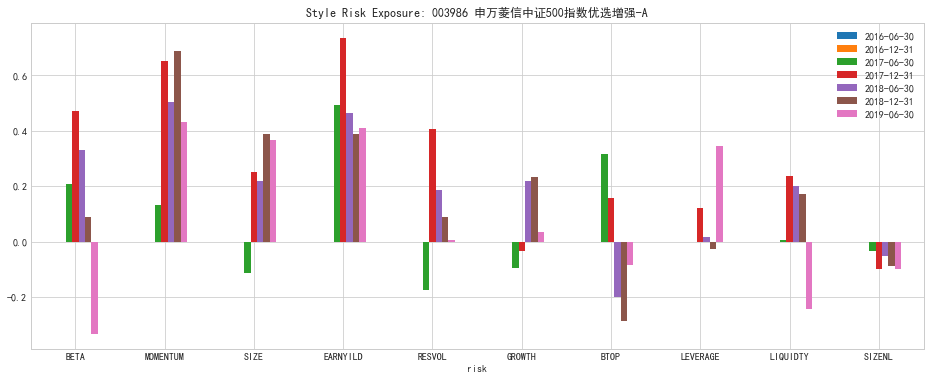

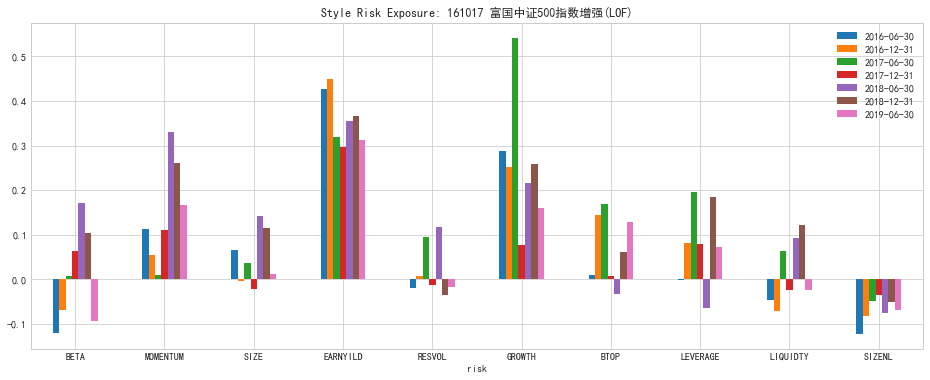

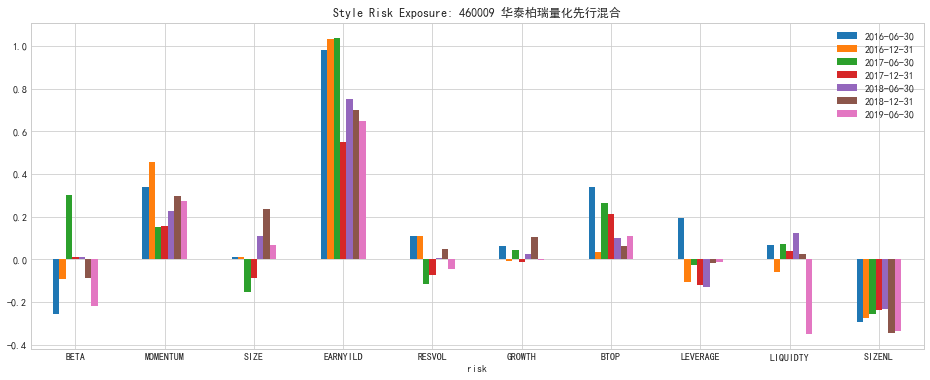

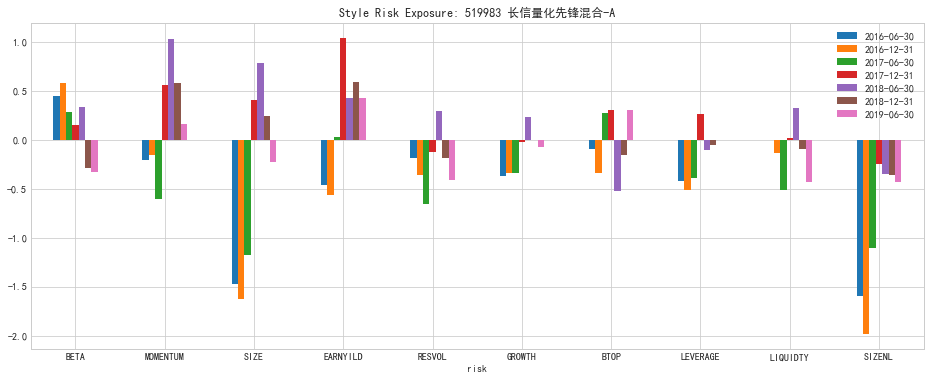

In [13]:
fund_tic = '000478'
for fund_tic in plot_rel_exp_df.columns:
    fund_name = fund_tic_map[fund_tic]

    plot_df = plot_rel_exp_df[fund_tic].unstack()
    plot_df = plot_df[plot_df.index>'20160101']
    plot_df = plot_df.T
    se = plot_df.loc['COUNTRY'] > -0.5
    plot_df = plot_df[se.index]

    plot_df.columns = [x.strftime('%Y-%m-%d') for x in plot_df.columns]

    ax = plot_df.loc[risk_styles].plot(kind='bar', figsize=(16, 6));
    ax.set_xticklabels(plot_df.loc[risk_styles].index, rotation=0);
    ax.set_title('Style Risk Exposure: ' + fund_tic + ' ' + fund_name);
    # ax = plot_df.loc[industry_styles].plot(kind='bar', figsize=(16, 5));
    # ax.set_xticklabels(plot_df.loc[industry_styles].index, rotation=45);
    # ax.set_title('Industry Exposure: ' + fund_tic + ' ' + fund_name);

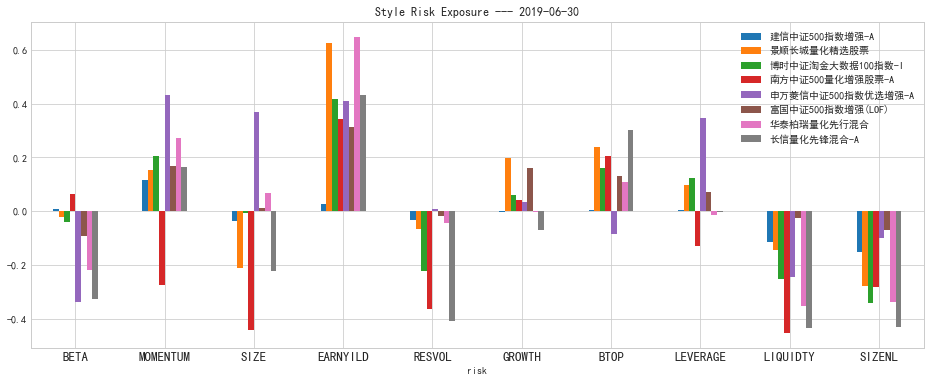

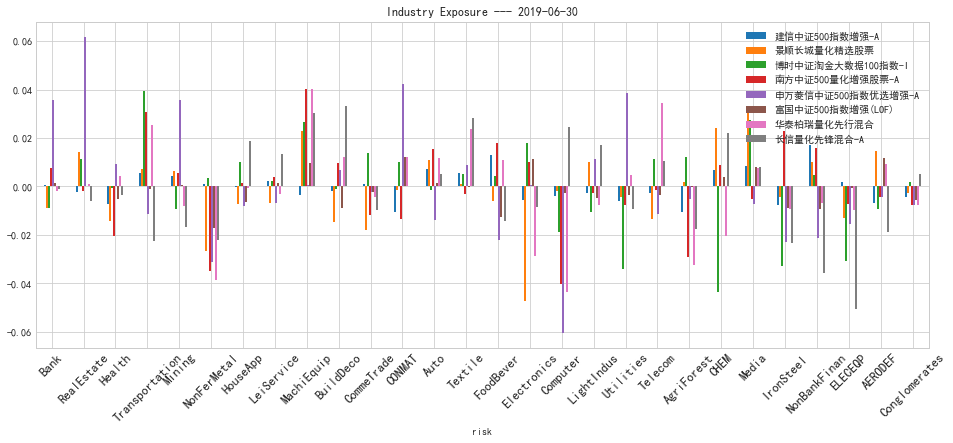

In [14]:
plot_df = plot_rel_exp_df.loc['2019-06-30':].groupby('risk').mean()

plot_df.columns = [fund_tic_map[x] for x in plot_df.columns]

ax = plot_df.loc[risk_styles].plot(kind='bar', figsize=(16, 6));
ax.set_xticklabels(plot_df.loc[risk_styles].index, rotation=0, fontsize=13);
ax.set_title('Style Risk Exposure --- 2019-06-30');

ax = plot_df.loc[industry_styles].plot(kind='bar', figsize=(16, 6));
ax.set_xticklabels(plot_df.loc[industry_styles].index, rotation=45, fontsize=13);
ax.set_title('Industry Exposure --- 2019-06-30');

In [22]:
np.round(plot_df.loc[risk_styles].T, 3)

risk,BETA,MOMENTUM,SIZE,EARNYILD,RESVOL,GROWTH,BTOP,LEVERAGE,LIQUIDTY,SIZENL
建信中证500指数增强-A,0.031,0.103,-0.026,0.099,0.006,0.052,-0.009,-0.027,-0.123,-0.118
景顺长城量化精选股票,0.043,0.235,-0.222,0.595,-0.043,0.088,0.077,0.001,-0.116,-0.242
博时中证淘金大数据100指数-I,0.010,0.479,0.303,0.504,-0.110,0.050,-0.011,0.043,-0.061,-0.312
南方中证500量化增强股票-A,-0.024,-0.255,-0.406,0.267,-0.312,-0.045,0.140,-0.164,-0.385,-0.130
申万菱信中证500指数优选增强-A,0.028,0.541,0.326,0.420,0.094,0.163,-0.191,0.112,0.042,-0.080
富国中证500指数增强(LOF),0.061,0.253,0.091,0.345,0.022,0.211,0.053,0.064,0.064,-0.065
华泰柏瑞量化先行混合,-0.098,0.266,0.137,0.698,0.004,0.042,0.090,-0.054,-0.069,-0.304
长信量化先锋混合-A,-0.092,0.594,0.268,0.481,-0.099,0.051,-0.122,-0.052,-0.067,-0.380


In [26]:
# np.round(plot_df.loc[industry_styles], 3)

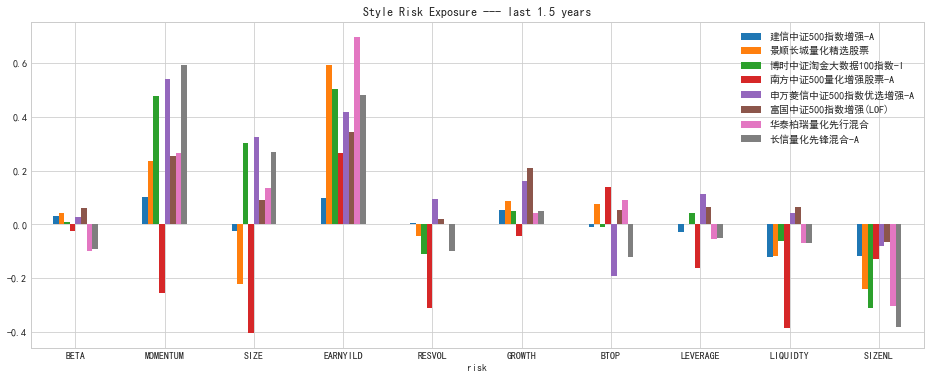

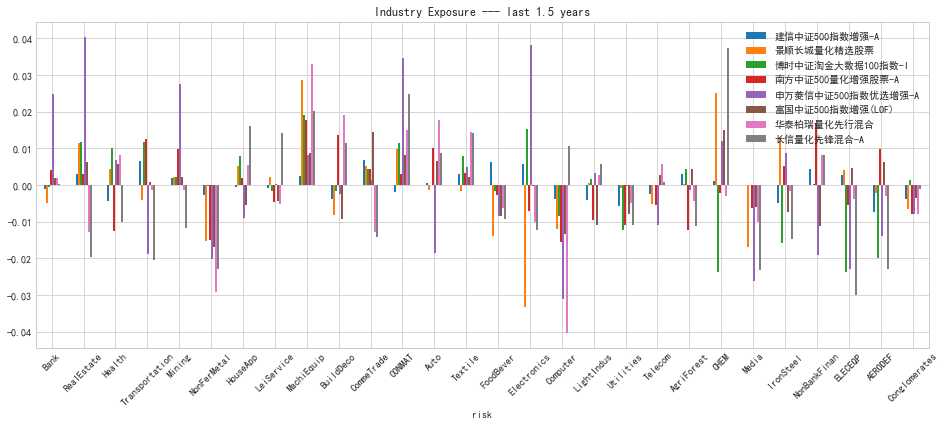

In [15]:
plot_df = plot_rel_exp_df.loc['2018-06-30':].groupby('risk').mean()

plot_df.columns = [fund_tic_map[x] for x in plot_df.columns]

ax = plot_df.loc[risk_styles].plot(kind='bar', figsize=(16, 6));
ax.set_xticklabels(plot_df.loc[risk_styles].index, rotation=0);
ax.set_title('Style Risk Exposure --- last 1.5 years');

ax = plot_df.loc[industry_styles].plot(kind='bar', figsize=(16, 6));
ax.set_xticklabels(plot_df.loc[industry_styles].index, rotation=45);
ax.set_title('Industry Exposure --- last 1.5 years');